In [ ]:
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

sys.path.append("..")
# this is what you need for python script
# sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))

from partipy.arch import AA

plt.style.use("dark_background")

- Define simple function to profile execution time

In [2]:
def measure_execution_time(func, n_runs=5):
    times = []
    for _ in tqdm(range(n_runs)):
        start = time.perf_counter()
        func()
        end = time.perf_counter()
        times.append(end - start)
    times = np.array(times)
    return times

- Define function to simulate data 

In [3]:
def simulate(
    n_samples: int,
    n_archetypes: int,
    n_dimensions: int,
    noise_std: float,
    seed: int = 42,
):
    assert noise_std >= 0

    rng = np.random.default_rng(seed=seed)
    Z = rng.uniform(low=-1, high=1, size=(n_archetypes, n_dimensions))
    A = rng.exponential(scale=1, size=(n_samples, n_archetypes))
    A /= A.sum(axis=1, keepdims=True)
    X = A @ Z
    if noise_std > 0:
        X += rng.normal(loc=0, scale=noise_std, size=X.shape)

    assert np.all(np.isclose(A.sum(axis=1), 1))
    assert A.min() > 0

    return X, A, Z

In [4]:
def plot_simulated_data(setting):
    assert setting["n_dimensions"] == 2
    X, A, Z = simulate(
        n_samples=setting["n_samples"],
        n_archetypes=setting["n_archetypes"],
        n_dimensions=setting["n_dimensions"],
        noise_std=setting["noise_std"],
    )
    plt.scatter(X[:, 0], X[:, 1], c="blue", alpha=0.25)
    plt.scatter(Z[:, 0], Z[:, 1], c="red", alpha=0.5)
    plt.show()

In [5]:
config = {
    "plotting": {
        "n_samples": 1_000,
        "n_archetypes": 3,
        "n_dimensions": 2,
        "noise_std": 0.1,
    },
    "tiny": {
        "n_samples": 1_000,
        "n_archetypes": 5,
        "n_dimensions": 30,
        "noise_std": 0.0,
    },
    "small": {
        "n_samples": 10_000,
        "n_archetypes": 5,
        "n_dimensions": 30,
        "noise_std": 0.0,
    },
    "medium": {
        "n_samples": 100_000,
        "n_archetypes": 5,
        "n_dimensions": 30,
        "noise_std": 0.0,
    },
    "large": {
        "n_samples": 1_000_000,
        "n_archetypes": 5,
        "n_dimensions": 30,
        "noise_std": 0.0,
    },
}

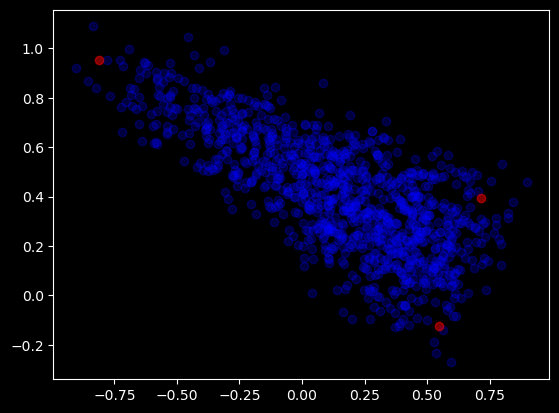

In [6]:
plot_simulated_data(config["plotting"])

In [7]:
settings_to_consider = ["tiny", "small", "medium"]
results_df_list = []
for algo_str in ["projected_gradients", "frank_wolfe"]:
    print(algo_str)
    for setting_str in settings_to_consider:
        print(setting_str)
        setting = config[setting_str]
        X, A, Z = simulate(
            n_samples=setting["n_samples"],
            n_archetypes=setting["n_archetypes"],
            n_dimensions=setting["n_dimensions"],
            noise_std=setting["noise_std"],
        )
        times = measure_execution_time(lambda: AA(n_archetypes=setting["n_archetypes"],
                                                  init="random",
                                                  optim=algo_str,
                                                  weight=None,
                                                  ).fit(X=X))
        results_df_list.append(
            pd.DataFrame({"algorithm": algo_str, "setting": setting_str, "time": times})
        )
results_df = pd.concat(results_df_list, axis=0)
results_df["setting"] = pd.Categorical(
    results_df["setting"], categories=settings_to_consider
)

projected_gradients
tiny


100%|██████████| 5/5 [00:01<00:00,  2.73it/s]


small


100%|██████████| 5/5 [00:23<00:00,  4.62s/it]


medium


100%|██████████| 5/5 [05:18<00:00, 63.63s/it]


frank_wolfe
tiny


100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


small


100%|██████████| 5/5 [00:08<00:00,  1.68s/it]


medium


100%|██████████| 5/5 [01:51<00:00, 22.30s/it]


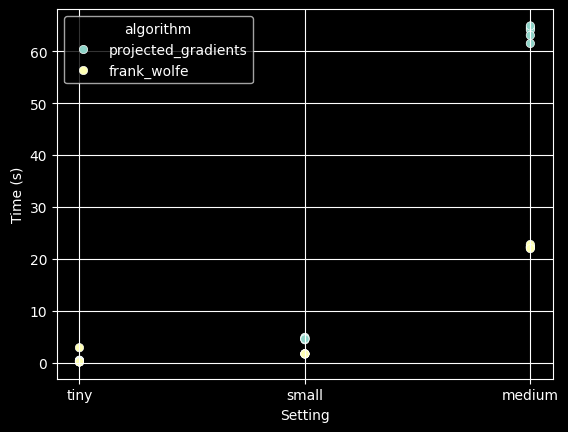

In [8]:
plt.ylabel("Time (s)")
sns.scatterplot(data=results_df, x="setting", y="time", hue="algorithm")
plt.grid()
plt.xlabel("Setting")
plt.show()

In [9]:
results_df

,algorithm,setting,time
0,projected_gradients,tiny,0.464368
1,projected_gradients,tiny,0.335042
2,projected_gradients,tiny,0.399264
3,projected_gradients,tiny,0.316450
4,projected_gradients,tiny,0.316960
0,projected_gradients,small,4.859639
1,projected_gradients,small,4.525492
2,projected_gradients,small,4.738486
3,projected_gradients,small,4.399299
4,projected_gradients,small,4.550522


In [10]:
settings_to_consider = ["tiny", "small", "medium"]
results_df_list_fs = []
for algo_str in ["projected_gradients", "frank_wolfe"]:
    print(algo_str)
    for setting_str in settings_to_consider:
        print(setting_str)
        setting = config[setting_str]
        X, A, Z = simulate(
            n_samples=setting["n_samples"],
            n_archetypes=setting["n_archetypes"],
            n_dimensions=setting["n_dimensions"],
            noise_std=setting["noise_std"],
        )
        times = measure_execution_time(lambda: AA(n_archetypes=setting["n_archetypes"],
                                                  init="furthest_sum",
                                                  optim=algo_str,
                                                  weight=None,
                                                  ).fit(X=X))
        results_df_list_fs.append(
            pd.DataFrame({"algorithm": algo_str, "setting": setting_str, "time": times})
        )
results_df_fs = pd.concat(results_df_list_fs, axis=0)
results_df_fs["setting"] = pd.Categorical(
    results_df_fs["setting"], categories=settings_to_consider
)

projected_gradients
tiny


100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


small


100%|██████████| 5/5 [00:31<00:00,  6.25s/it]


medium


100%|██████████| 5/5 [08:37<00:00, 103.54s/it]


frank_wolfe
tiny


  0%|          | 0/5 [00:00<?, ?it/s]/gpfs/bwfor/home/hd/hd_hd/hd_fb235/thesis/ParTIpy/ParTIpy/optim.py:269: LineSearchWarning: The line search algorithm did not converge
  gamma = line_search(f, grad_f, B.flatten(), d)[0]
100%|██████████| 5/5 [00:10<00:00,  2.08s/it]


small


100%|██████████| 5/5 [01:17<00:00, 15.57s/it]


medium


100%|██████████| 5/5 [22:15<00:00, 267.11s/it]


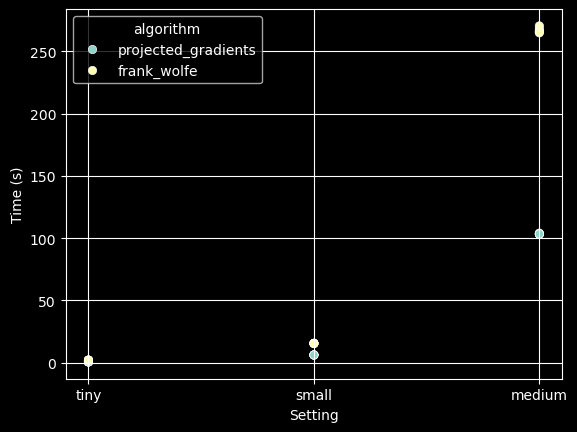

In [11]:
plt.ylabel("Time (s)")
sns.scatterplot(data=results_df_fs, x="setting", y="time", hue="algorithm")
plt.grid()
plt.xlabel("Setting")
plt.show()